In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat

In [2]:
def geom_mean(DATA):
    geom_mean = []
    for i in range(len(DATA)):
        geom_mean.append(stat.geometric_mean(DATA[i]))
    return np.asarray(geom_mean, dtype = np.float32)

In [3]:
def geom_mean_for_phase(DATA):
    abs_phase = []
    geom_mean = []
    for i in range(len(DATA)):
        abs_phase.append(list(map(abs, DATA[i])))
        geom_mean.append(-stat.geometric_mean(abs_phase[i]))
    return np.asarray(geom_mean, dtype = np.float32)

In [4]:
def big_filtr(DATA, not32 = True, i_ch = False, iii_ch = False):
    rows, clmns = DATA.shape
    good_data = []
    if not32 == True:
        for i in range(rows):
            good_data.append(list(DATA[i][DATA[i] < 1e32]))
    elif i_ch == True:
        for i in range(rows):
            good_data.append(list(DATA[i][(DATA[i] <= 90) & (DATA[i] >= 0)]))
    elif iii_ch == True:
        for i in range(rows):
            good_data.append(list(DATA[i][(DATA[i] <= -90) & (DATA[i] >= -180)]))
        
    return good_data

In [5]:
def filtr_for_impedance(DATA_R, DATA_I):
    rows, clmns = DATA_R.shape
    good_data_r = []
    good_data_i = []
    for i in range(rows):
        good_data_r.append(list(DATA_R[i][(DATA_R[i] < 1e32) & (DATA_I[i] < 1e32)]))
        good_data_i.append(list(DATA_I[i][(DATA_R[i] < 1e32) & (DATA_I[i] < 1e32)]))
    return good_data_r, good_data_i
# булеву маску достаточно сделать по одному, так как пустные множества 
# у них будут совпадать(фильтры одинаковые)

In [6]:
# удаляем пустые множества и делаем булеву маску для модуля тензора импеданса
def bln_mask_nan_imp(DATA_R, DATA_I): 
    bln_msk = []
    MODULE_IMP = []
    for i in range(len(DATA_R)):
        if bool(DATA_R[i]) == 0:
            bln_msk.append(False)
        else:
            bln_msk.append(True)
            module_imp = []
            for j in range(len(DATA_R[i])):
                module_imp.append(np.sqrt(DATA_R[i][j]**2 + DATA_I[i][j]**2))
            MODULE_IMP.append(module_imp)
            
    return bln_msk, MODULE_IMP

In [7]:
def bln_mask_nan(DATA):
    bln_msk = []
    good_data = []
    for i in range(len(DATA)):
        if bool(DATA[i]) == 0:
            bln_msk.append(False)
        else:
            bln_msk.append(True)
            good_data.append(DATA[i])
    return bln_msk, good_data

In [8]:
# проверка невозрастания функции модуля импеданса
def non_incr(DATA):
    bln_msk_non_incr = [True]
    i = 1
    z_start = DATA[0]
    while True:
        if i >= len(DATA):
            break
        else:
            if z_start < DATA[i]:
                while z_start < DATA[i]:
                    bln_msk_non_incr.append(False)
                    i += 1
                    if i == len(DATA):
                        break
                if i == len(DATA):
                    break
                bln_msk_non_incr.append(True)
                z_start = DATA[i]
                i += 1         
            else:
                bln_msk_non_incr.append(True)
                z_start = DATA[i]
                i += 1
    return bln_msk_non_incr

In [9]:
# делаем из двух булевых масок одну
def one_bln_from_two(bln1, bln2):
    return [bool(i*j) for i, j in zip(bln1, bln2)]

In [10]:
# расчитываем вес зашумленных данных (по оси у)
def weig(DATA):
    weight = []
    for i in range(len(DATA)):
        weight.append(1/stat.variance(DATA[i]))
    return  np.asarray(weight, dtype = np.float32)

In [11]:
# вытягиваем массив данных и считаем сколько игреков для каждого икса
def flat(DATA):
    n = []
    flat_data = []
    for i in range(len(DATA)):
        n.append(len(DATA[i]))
        flat_data += DATA[i]
    return n, flat_data 

In [12]:
def repeat_data(DATA, n):
    return np.repeat(DATA, n)

In [13]:
def open_exp_data(file_name, data_name):
    DATA = []
    with open(file_name, 'r') as file:
        if '>FREQ' in data_name:
            for line in file:
                if data_name in line:
                    for line in file:
                        try:
                            DATA += [1/float(value) for value in line.split()]
                        except ValueError: 
                            break
                    break
            DATA_AR = np.asarray(DATA, dtype = np.float32)
        else:
            for line in file:
                if data_name in line:
                    data = []
                    for line in file:
                        try:
                            data += [float(value) for value in line.split()]
                        except ValueError:
                            DATA.append(data)
                            break
            DATA_AR = np.asarray(DATA, dtype = np.float32).transpose() 
            
    return DATA_AR

In [14]:
def spline_progonka(good_period, good_data):
    
    h = []
    n = len(good_period)
    for i in range(n - 1):
        h.append(good_period[i + 1] - good_period[i])
   
    a = [0]
    b = [-1]
    c = [0]
    d = [0]
    ksi = [c[0]/b[0]]
    etta = [d[0]/b[0]]
    for i in range(1, n - 1):
        a.append((h[i-1]/6))
        b.append((-(h[i-1] + h[i])/3))
        c.append(h[i]/6)
        d.append((good_data[i+1] - good_data[i])/h[i] - (good_data[i] - good_data[i-1])/h[i-1])
        ksi.append(c[i]/(b[i] - ksi[i-1] * a[i]))
        etta.append((a[i] * etta[i-1] - d[i])/(b[i] - ksi[i-1] * a[i]))
    a.append(0)
    b.append(-1)
    c.append(0)
    d.append(0)
    etta.append((a[n-1] * etta[n-2] - d[n-1])/(b[n-1] - ksi[n-2] * a[n-1]))
    
    m = [etta[n-1]]
    for i in range(1, n):
        m.append(ksi[-i] * m[i-1] + etta[-(i+1)])
    return m, h

In [15]:
def spline_matrix(good_period, good_data):
    
    h = []
    n = len(good_period)
    for i in range(n - 1):
        h.append(good_period[i + 1] - good_period[i])
   
    A = np.zeros((n, n))
    H = np.zeros((n, n))
              
    for i in range(n):
        if i == 0 or i == n-1:
            A[i][i] = 1
        else:
            A[i][i] = (h[i-1] + h[i])/3
            H[i][i] = -(1/h[i-1] + 1/h[i])
            for j in range(n):
                if j == i - 1:
                    A[i][j] = h[j]/6
                    H[i][j] = 1/h[j]
                elif j == i + 1:
                    A[i][j] = h[i]/6
                    H[i][j] = 1/h[i]
                    break
    m = np.linalg.solve(A, np.dot(H, good_data))
    m = list(m)
    return m.reverse()

In [16]:
def smoothing_spline_mine(good_period, good_data, w, s=0):
    h = []
    n = len(good_period)
    for i in range(n - 1):
        h.append(good_period[i + 1] - good_period[i])
    A = np.zeros((n, n))
    P = np.zeros((n, n))
    H = np.zeros((n, n))
              
    for i in range(n):
        P[i][i] = w[i]
        if i == 0 or i == n-1:
            A[i][i] = 1
        else:
            A[i][i] = (h[i-1] + h[i])/3
            H[i][i] = -(1/h[i-1] + 1/h[i])
            for j in range(n):
                if j == i - 1:
                    A[i][j] = h[j]/6
                    H[i][j] = 1/h[j]
                elif j == i + 1:
                    A[i][j] = h[i]/6
                    H[i][j] = 1/h[i]
                    break
    
    P_inv = np.linalg.inv(P)
    H_t = np.transpose(H)
    A_t = np.transpose(A)
    A_inv = np.linalg.inv(A)

    # (s/2*H*P_inv*(H + A_t*A_inv*H) + A) * m = H * good_data
    m = np.linalg.solve(np.add(np.dot(np.dot(s/2 * H, P_inv), np.add(H, np.dot(np.dot(A_t, A_inv), H))), A), np.dot(H, good_data)) # n-1
    # mu = good_data - P_inv * (H + A_t*A_inv*H) * m
    mu = np.subtract(good_data, np.dot(np.dot(s/2 * P_inv, np.add(H, np.dot(np.dot(A_t, A_inv), H))), m)) # n
    
    m = list(m)
    return m.reverse(), mu, h

In [17]:
# считываем данные: период (ось х)
period = open_exp_data('OO-01_REH — копия.edi', '>FREQ NFREQ=90 // 90')

In [18]:
# считываем данные: сопротивление xу, фаза ух, компоненты тензора импеданса ху и ух  
rhoxy = open_exp_data('OO-01_REH — копия.edi', '>RHOXY NFREQ=90 ROT=RHOROT // 90')
phsyx = open_exp_data('OO-01_REH — копия.edi', '>PHSYX NFREQ=90 ROT=RHOROT // 90')
zxyr = open_exp_data('OO-01_REH — копия.edi', '>ZXYR NFREQ=90 ROT=ZROT // 90')
zxyi = open_exp_data('OO-01_REH — копия.edi', '>ZXYI NFREQ=90 ROT=ZROT // 90')
zyxr = open_exp_data('OO-01_REH — копия.edi', '>ZYXR NFREQ=90 ROT=ZROT // 90')
zyxi = open_exp_data('OO-01_REH — копия.edi', '>ZYXI NFREQ=90 ROT=ZROT // 90')

In [19]:
# фильтруем данные по значениям и поведению передаточных функций; удаляем пустые множества
bln_msk_rhoxy, good_rhoxy = bln_mask_nan(big_filtr(rhoxy))
bln_msk_phsyx, good_phsyx = bln_mask_nan(big_filtr(phsyx, not32 = False, i_ch = False, iii_ch = True))
good_zxyr, good_zxyi = filtr_for_impedance(zxyr, zxyi)
good_zyxr, good_zyxi = filtr_for_impedance(zyxr, zyxi)
bln_msk_zxy, zxy_abs = bln_mask_nan_imp(good_zxyr, good_zxyi)
bln_msk_zyx, zyx_abs = bln_mask_nan_imp(good_zyxr, good_zyxi)

In [20]:
# делаем будеву маску по критерию3
bln_msk_zxy_not_incr = non_incr(zxy_abs)
bln_msk_zyx_not_incr = non_incr(zyx_abs)

In [21]:
# фильруем период по булевым маскам без критерия3
good_period_rhoxy = period[bln_msk_rhoxy]
good_period_phsyx = period[bln_msk_phsyx]
good_period_zxy = period[bln_msk_zxy]
good_period_zyx = period[bln_msk_zyx]
# делаем из двух булевых масок одну с критерием3
bln_msk_rhoxy_cr3 = one_bln_from_two(bln_msk_rhoxy, bln_msk_zxy_not_incr)
bln_msk_phsyx_cr3 = one_bln_from_two(bln_msk_phsyx, bln_msk_zyx_not_incr)
bln_msk_zxy_cr3 = one_bln_from_two(bln_msk_zxy, bln_msk_zxy_not_incr)
bln_msk_zyx_cr3 = one_bln_from_two(bln_msk_zyx, bln_msk_zyx_not_incr)
#фильтруем период с крит3
good_period_rhoxy_cr3 = period[bln_msk_rhoxy_cr3]
good_period_phsyx_cr3 = period[bln_msk_phsyx_cr3]
good_period_zxy_cr3 = period[bln_msk_zxy_cr3]
good_period_zyx_cr3 = period[bln_msk_zyx_cr3]

In [22]:
# рассчитываем среднее геометрическое для передаточных функций
rhoxy_gm = geom_mean(good_rhoxy)
phsyx_gm = geom_mean_for_phase(good_phsyx)
zxy_abs_gm = geom_mean(zxy_abs)
zyx_abs_gm = geom_mean(zyx_abs)

In [23]:
# фильтруем среднее геометрическое передаточных функций по критерию3
rhoxy_gm_cr3 = rhoxy_gm[bln_msk_zxy_not_incr]
phsyx_gm_cr3 = phsyx_gm[bln_msk_zyx_not_incr]
zxy_abs_gm_cr3 = zxy_abs_gm[bln_msk_zxy_not_incr]
zyx_abs_gm_cr3 = zyx_abs_gm[bln_msk_zyx_not_incr]

In [24]:
# вытягиваем массивы сопротивление ху и фазы ух 
n_rhoxy, rhoxy_flat = flat(good_rhoxy)
n_phsyx, phsyx_flat = flat(good_phsyx)
# повторяем период для них
period_rhoxy_flat = repeat_data(good_period_rhoxy, n_rhoxy)
period_phsyx_flat = repeat_data(good_period_phsyx, n_phsyx)

In [26]:
# рассчитываем веса значений сопр ху и фазы ух с фильтром по кр3
w_good_rhoxy = weig(good_rhoxy)[bln_msk_zxy_not_incr]
w_good_phsyx = weig(good_phsyx)[bln_msk_zyx_not_incr]

In [100]:
def spline(good_period, good_data, period_flat, data_flat, pic_name, bilog_scale = False, semilog_scale =False):
    
    h = []
    n = len(good_period)
    for i in range(n - 1):
        h.append(good_period[i + 1] - good_period[i])
   
    a = [0]
    b = [-1]
    c = [0]
    d = [0]
    ksi = [c[0]/b[0]]
    etta = [d[0]/b[0]]
    for i in range(1, n - 1):
        a.append((h[i-1]/6))
        b.append((-(h[i-1] + h[i])/3))
        c.append(h[i]/6)
        d.append((good_data[i+1] - good_data[i])/h[i] - (good_data[i] - good_data[i-1])/h[i-1])
        ksi.append(c[i]/(b[i] - ksi[i-1] * a[i]))
        etta.append((a[i] * etta[i-1] - d[i])/(b[i] - ksi[i-1] * a[i]))
    a.append(0)
    b.append(-1)
    c.append(0)
    d.append(0)
    etta.append((a[n-1] * etta[n-2] - d[n-1])/(b[n-1] - ksi[n-2] * a[n-1]))
    
    m = [etta[n-1]]
    for i in range(1, n):
        m.append(ksi[-i] * m[i-1] + etta[-(i+1)])
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()
    ax.plot(period_flat, data_flat, '.', color = 'green')
    ax.set_xlabel('T, с')
    if bilog_scale == True:
        ax.set_ylabel(r'$\rho$'+'(xy), Ом')
        for i in range(1, n):
            x = np.linspace(good_period[i-1], good_period[i], 50)
            ax.loglog(x, ((m[-i] * (good_period[i] - x)**3 + m[-(i+1)] * (x - good_period[i-1])**3) / 6 + (good_data[i-1] - m[-i] * h[i - 1]**2 / 6) * (good_period[i] - x) + (good_data[i] - m[-(i+1)] * h[i - 1]**2 / 6) * (x - good_period[i-1])) / h[i - 1], color='red', linewidth=3)
            ax.grid('True')
            ax.axis('equal')
    elif semilog_scale == True:
        ax.set_ylabel(r'$\phi$'+'(yx), град')
        ax.set_ylim([-180, -90])
        for i in range(1, n):
            x = np.linspace(good_period[i-1], good_period[i], 50)
            ax.semilogx(x, ((m[-i] * (good_period[i] - x)**3 + m[-(i+1)] * (x - good_period[i-1])**3) / 6 + (good_data[i-1] - m[-i] * h[i - 1]**2 / 6) * (good_period[i] - x) + (good_data[i] - m[-(i+1)] * h[i - 1]**2 / 6) * (x - good_period[i-1])) / h[i - 1], color='red', linewidth=3)
            ax.grid('True')
    plt.savefig(pic_name+'.jpeg', dpi = 300)
    plt.show()

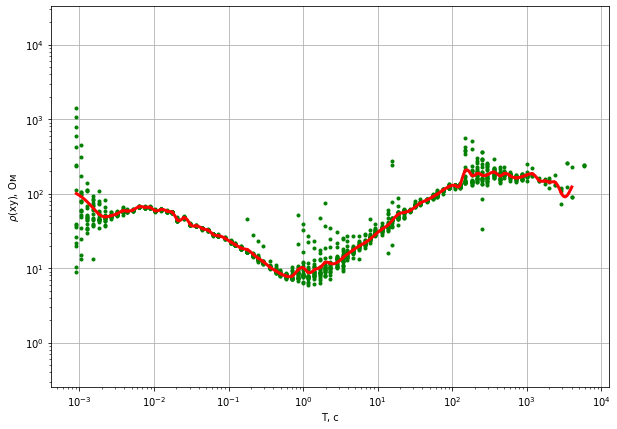

In [92]:
spline(good_period_rhoxy_cr3, rhoxy_gm_cr3, period_rhoxy_flat, rhoxy_flat, 'rhoxy5', bilog_scale = True)

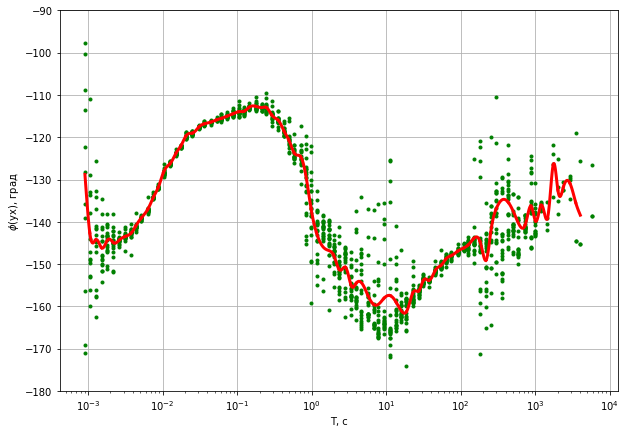

In [101]:
spline(good_period_phsyx_cr3, phsyx_gm_cr3, period_phsyx_flat, phsyx_flat, 'phsyx4', bilog_scale = False, semilog_scale=True)

In [107]:
def smoothing_spline(good_period, good_data, w, s, period_flat, data_flat, pic_name, bilog_scale = False, semilog_scale = False):
    h = []
    n = len(good_period)
    for i in range(n - 1):
        h.append(good_period[i + 1] - good_period[i])
    A = np.zeros((n, n))
    P = np.zeros((n, n))
    H = np.zeros((n, n))
              
    for i in range(n):
        P[i][i] = w[i]
        if i == 0 or i == n-1:
            A[i][i] = 1
        else:
            A[i][i] = (h[i-1] + h[i])/3
            H[i][i] = -(1/h[i-1] + 1/h[i])
            for j in range(n):
                if j == i - 1:
                    A[i][j] = h[j]/6
                    H[i][j] = 1/h[j]
                elif j == i + 1:
                    A[i][j] = h[i]/6
                    H[i][j] = 1/h[i]
                    break
    
    P_inv = np.linalg.inv(P)
    H_t = np.transpose(H)
    A_t = np.transpose(A)
    A_inv = np.linalg.inv(A)

    # (s/2*H*P_inv*(H + A_t*A_inv*H) + A) * m = H * good_data
    m = np.linalg.solve(np.add(np.dot(np.dot(s/2 * H, P_inv), np.add(H, np.dot(np.dot(A_t, A_inv), H))), A), np.dot(H, good_data)) # n-1
    # mu = good_data - P_inv * (H + A_t*A_inv*H) * m
    mu = np.subtract(good_data, np.dot(np.dot(s/2 * P_inv, np.add(H, np.dot(np.dot(A_t, A_inv), H))), m)) # n
    
    m = list(m)
    m.reverse()
   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()
    ax.plot(period_flat, data_flat, '.', color = 'green')
    ax.set_xlabel('T, с')
    if bilog_scale == True:
        ax.set_ylabel(r'$\rho$'+'(xy), Ом')
        for i in range(1, n):
            x = np.linspace(good_period[i-1], good_period[i], 50)
            ax.loglog(x, ((m[-i] * (good_period[i] - x)**3 + m[-(i+1)] * (x - good_period[i-1])**3) / 6 + (mu[i-1] - m[-i] * h[i - 1]**2 / 6) * (good_period[i] - x) + (mu[i] - m[-(i+1)] * h[i - 1]**2 / 6) * (x - good_period[i-1])) / h[i - 1], color='red', linewidth=3)
            ax.grid('True')
            ax.axis('equal')
    elif semilog_scale == True:
        ax.set_ylabel(r'$\phi$'+'(yx), град')
        ax.set_ylim([-180, -90])
        for i in range(1, n):
            x = np.linspace(good_period[i-1], good_period[i], 50)
            ax.semilogx(x, ((m[-i] * (good_period[i] - x)**3 + m[-(i+1)] * (x - good_period[i-1])**3) / 6 + (mu[i-1] - m[-i] * h[i - 1]**2 / 6) * (good_period[i] - x) + (mu[i] - m[-(i+1)] * h[i - 1]**2 / 6) * (x - good_period[i-1])) / h[i - 1], color='red', linewidth=3)
            ax.grid('True')
    plt.savefig(pic_name+'.jpeg', dpi = 300)
    plt.show()

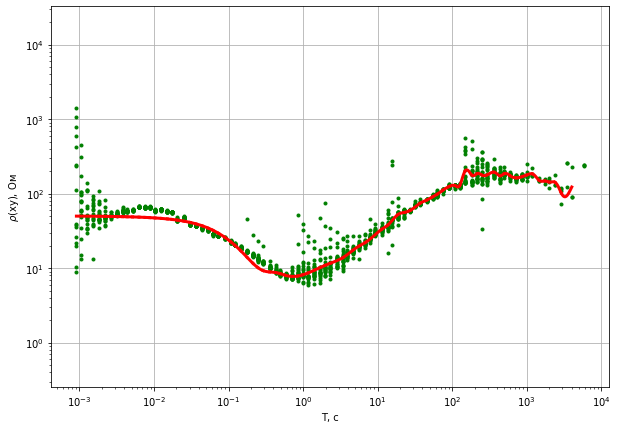

In [108]:
smoothing_spline(good_period_rhoxy_cr3, rhoxy_gm_cr3, w_good_rhoxy, 1e-3, period_rhoxy_flat, rhoxy_flat, 'rhoxy_smth2', bilog_scale = True, semilog_scale = False)

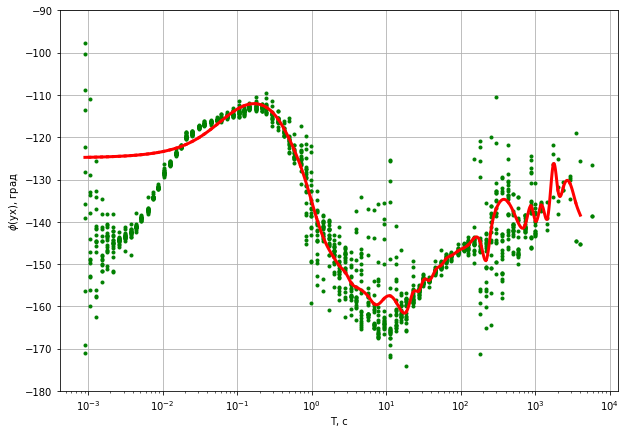

In [109]:
smoothing_spline(good_period_phsyx_cr3, phsyx_gm_cr3, w_good_phsyx, 1e-3, period_phsyx_flat, phsyx_flat, 'phsyx_smth2', bilog_scale = False, semilog_scale = True)